In [3]:
import sys
sys.path.append("..")
import download_utils
import tqdm_utils

### Prologue
 *  Using the original DB, the model has been training for 5 days. 
 *  I used the DB and architecture used in the 1st course of the specialization, the kfw dataset. 
 *  Since it works with lower resolution, the model trained faster to produce better results

/home/alfredotedesco/.pyenv/versions/3.5.9/envs/deep-359/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


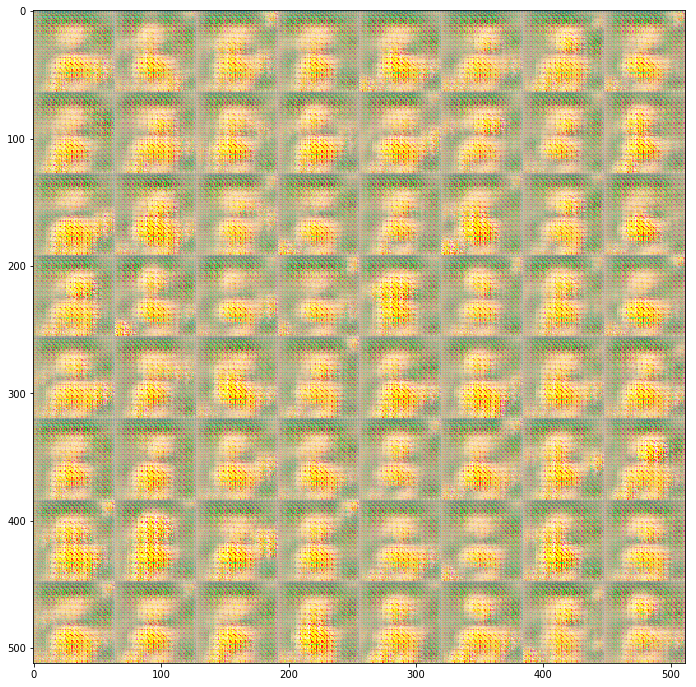

In [78]:
# picture of model partially trained (needs more training) with high res dataset:
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.imshow(scipy.misc.imread('sample_faces/train_01_1814.png'))

In [10]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
import scipy.misc

from ops import *
from utils import *

In [11]:
download_utils.link_week_4_resources()

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

In [14]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [27]:
DATA_PATH = 'img_align_celeba/img_align_celeba' # Path to the dataset with celebA faces
#Z_DIM=100 # Dimension of face's manifold
#GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator


IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X =  8 # Number images in merged image
#MERGE_Y = BATCH_SIZE//MERGE_X
CODE_SIZE = 256
IMG_SHAPE = (36,36,3)

In [28]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

In [29]:
generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))


Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [30]:
from keras.models import Sequential as Sequential
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

# like autoencoders 
discriminator.add(L.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))
discriminator.add(L.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))
discriminator.add(L.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))
discriminator.add(L.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation='elu') )
discriminator.add(L.MaxPooling2D(padding='same'))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
# I prefer to use softmax with two classes
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax, kernel_regularizer=keras.regularizers.l2(0.01)))


Now let's define generator and discriminator.

In [31]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)


Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [35]:
########################
#discriminator training# # as suggested by github page
########################

# NOTICE LOGS ARE NOT NEEDED FOR FASTER TRAINING

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])  # and how close generated ones to being fake

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)
g_loss = -tf.reduce_mean(logp_gen[:,1])  # how close generated to being real



Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [36]:

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)
gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

In [37]:
s.run(tf.global_variables_initializer())

Functions for training and evaluations.

In [38]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

In [39]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

## Training GAN (1 point + 2 for good results)

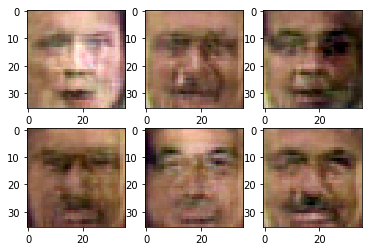

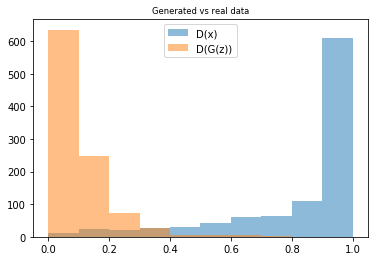

Current iteration 4700
4701
4702
4703


KeyboardInterrupt: 

In [42]:
from IPython import display
SAVE_DIR = 'keras-model'
MODEL_NAME = 'keras-model'

for epoch in tqdm_utils.tqdm_notebook_failsafe(range(50000)):
    print(epoch)
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %20==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        print('Current iteration', epoch)
        saver = tf.train.Saver()
        saver.save(s, os.path.join(SAVE_DIR, MODEL_NAME))
        

## Face interpolation (1 point)
Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

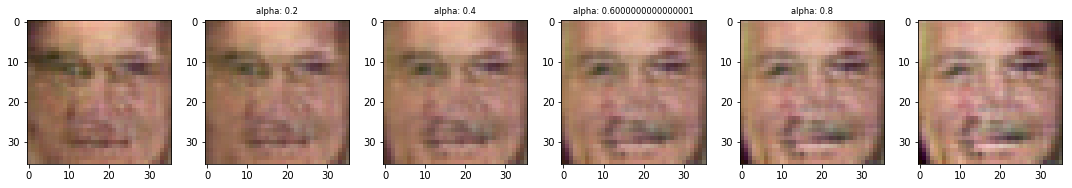

In [72]:
np.random.seed(44)
z1 = np.random.normal(size=(1, CODE_SIZE)).astype('float32')
z2 = np.random.normal(size=(1, CODE_SIZE)).astype('float32')


fig, ax = plt.subplots(1, 6)
fig.set_size_inches(15, 15)
ax[0].imshow(generator.predict(z2).reshape(IMG_SHAPE),cmap="gray", interpolation="none")

a = .2
for j in range(1, 5):
    z3 = z1 * a + (1-a) * z2
    
    ax[j].imshow(generator.predict(z3).reshape(IMG_SHAPE),cmap="gray", interpolation="none")
    ax[j].set_title('alpha: ' + str(a))
    
    a += .2
    
ax[5].imshow(generator.predict(z1).reshape(IMG_SHAPE),cmap="gray", interpolation="none")

plt.tight_layout()
plt.show()

## Adding a smile (1 point + 1 point for good results)
* Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).
* Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.
* Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

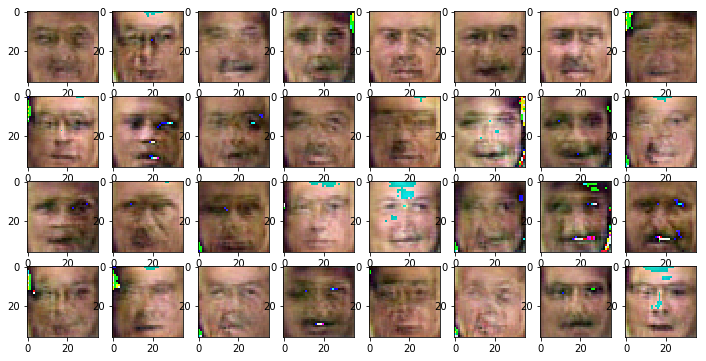

In [95]:
# display random bacth to look for smiles
np.random.seed(13439)
Z = np.random.normal(size=(32, CODE_SIZE)).astype('float32')
fig, ax = plt.subplots(4, 8)
fig.set_size_inches(12, 6)
Z2 = generator.predict(Z)
k = 0
for i in range(4):
    for j in range(8):
        ax[i, j].imshow(Z2[k].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        k += 1 

In [108]:
vectors_smiles = Z[[2,6, 11, 15,20]]
v_smile = np.mean(vectors_smiles, axis=0) - np.mean(Z[-np.array([2,6, 11, 15,20])], axis=0)
v_smile = v_smile.reshape(1, 256)
v_smile.shape

(1, 256)

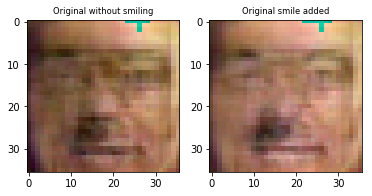

In [109]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Z2[12].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
ax[0].set_title('Original without smiling')
ax[1].imshow(generator.predict(Z[12] + v_smile).reshape(IMG_SHAPE),cmap="gray", interpolation="none")
ax[1].set_title('Original smile added')


If faces looks really cool, add bonus 1 point to your score.